# Keras

[**Keras**](https://keras.io/) is a high-level API that allows to easily build, train, evaluate, and execute neural networks. To perform the heavy computations required by neural networks, it relies on a **computation backend**. At present, we can choose from several popular open source libraries: **TensorFlow** (which is bundled with its own Keras implementation), **Microsoft Cognitive Toolkit (CNTK)**, **Theano**, **Apache MXNet**, **Apple’s Core ML**, and **PlaidML**. The other popular library is **PyTorch**, which API is quite similar to Keras’s (because both were inspired by Scikit-Learn).

## Build a Classifier

First, we load the **Fashion MNIST** dataset, which has the same format as MNIST (70,000 grayscale images of 28 × 28 pixels each, with 10 classes), but the images represent fashion items from the online retailer Zalando, rather than handwritten digits, so each class is more diverse, and the problem turns out to be significantly more challenging than MNIST. Keras (like SciKitLearn) provides some utility functions to fetch and load common datasets.

In [179]:
import keras
from keras.datasets import fashion_mnist

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

print('Dataset shape:', X_train_full.shape)

Dataset shape: (60000, 28, 28)


The labels are the class IDs (represented as uint8), from 0 to 9, we need the list of class names to know what we are dealing with:

In [180]:
print('Class IDs:', y_train)

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

print('Class name of sample 0: ', class_names[y_train[0]])

Class IDs: [4 0 7 ... 3 0 5]
Class name of sample 0:  Coat


Let's take a look at a sample of the images in the dataset:

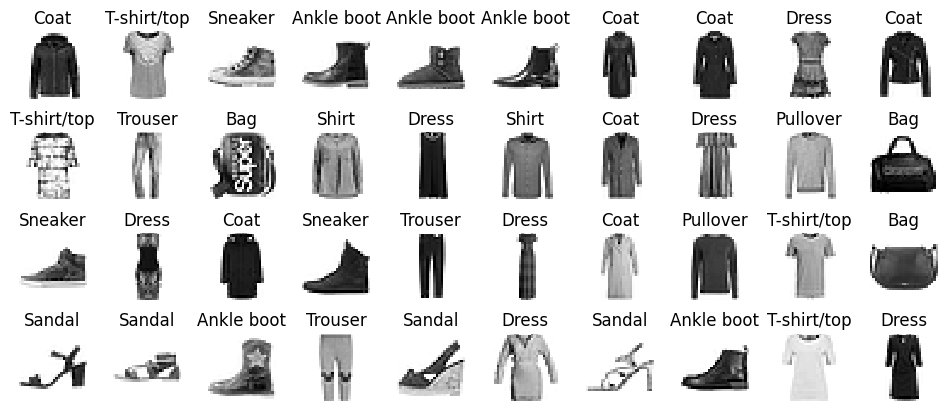

In [181]:
n_rows = 4
n_cols = 10

plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Now let’s build MLP with two hidden layers. We can use the **Sequential model**, which is the simplest kind of Keras model. It is just a single stack of layers connected sequentially. As fhe first layer we use a **Flatten layer**, it does not have any parameter, it is just there to do some simple preprocessing, in particular it converts each input image into a 1D array. Since it is the first layer in the model, we have to specify the input_shape. Then we the two  **Dense hidden layer** with 300 and 100 neurons, using the ReLU activation function. Finally, we add a **Dense output layer** with 10 neurons (one per class), using the softmax activation function:

In [205]:
model = keras.models.Sequential(name='sequential_model')

model.add(keras.layers.Flatten(input_shape=[28, 28], name='flatten_layer'))
model.add(keras.layers.Dense(300, activation="relu", name='hidden_layer_1'))
model.add(keras.layers.Dense(100, activation="relu", name='hidden_layer_2'))
model.add(keras.layers.Dense(10, activation="softmax", name='output_layer'))

The **summary()** method can be used to displays all the model’s layers, including each layer’s name (which is automatically generated unless we set it when creating the layer), its output shape and its number of parameters. The summary ends with **the total number of parameters**, including trainable and non-trainable parameters.

In [206]:
model.summary()

Model: "sequential_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_layer (Flatten)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Note that **Dense layers often have a lot of parameters**. For example, the first
hidden layer has 784×300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters. This gives the model quite a lot of flexibility to fit the training data, but it also means that the model runs the risk of overfitting, especially when you do not have a lot of training data. All the parameters of a layer can be accessed using its **get_weights()** and
**set_weights()** methods.

In [209]:
hidden_layer_1 = model.layers[1]
print("Hidden layer 1 name:", hidden_layer_1.name)

weights, biases = hidden_layer_1.get_weights()

print("Hidden layer 1 weights shape: ", weights.shape)
print("Hidden layer 1 bias shape: ",biases.shape)

Hidden layer 1 name: hidden_layer_1
Hidden layer 1 weights shape:  (784, 300)
Hidden layer 1 bias shape:  (300,)


The Dense layer **initialized connection weights randomly** (which is needed **to break symmetry**), and the biases were initialized to zeros, which is fine. After a model is created, we have to call the **compile()** method to specify the loss function and the optimizer to use. Optionally, we can specify a list of extra metrics to compute during training and evaluation.

In [210]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In the example, we use the **sparse_categorical_crossentropy loss** because we have sparse labels (i.e., for each instance, there is just a target class index, from 0 to 9), and the classes are exclusive. If instead we had one target probability per class for each instance (such as one-hot vectors), then we would need to use the **categorical_crossentropy loss** instead. If we were doing binary classification (with one or more binary labels), then we would we would use the **binary_crossentropy loss**. Now the model is ready to be trained. For this we simply need to call the  **fit()** method, passing it the input features (X_train), the target classes (y_train), the number of epochs to train and the validation set. If not specified, the **batch_size** is set to 32. Keras will **measure the loss and the extra metrics on this set at the end of each epoch, which is very useful to see how well the model really performs**. If the performance on the training set is much better than on the validation set, our model is probably overfitting the training set.

In [211]:
history = model.fit(X_train, y_train, epochs=20, verbose=2, validation_data=(X_valid, y_valid))

Epoch 1/20


1719/1719 - 3s - 2ms/step - accuracy: 0.8284 - loss: 0.4825 - val_accuracy: 0.8570 - val_loss: 0.3840
Epoch 2/20
1719/1719 - 3s - 2ms/step - accuracy: 0.8666 - loss: 0.3638 - val_accuracy: 0.8744 - val_loss: 0.3512
Epoch 3/20
1719/1719 - 3s - 2ms/step - accuracy: 0.8799 - loss: 0.3255 - val_accuracy: 0.8854 - val_loss: 0.3106
Epoch 4/20
1719/1719 - 3s - 2ms/step - accuracy: 0.8872 - loss: 0.3035 - val_accuracy: 0.8864 - val_loss: 0.3168
Epoch 5/20
1719/1719 - 3s - 2ms/step - accuracy: 0.8933 - loss: 0.2845 - val_accuracy: 0.8778 - val_loss: 0.3613
Epoch 6/20
1719/1719 - 3s - 2ms/step - accuracy: 0.8997 - loss: 0.2681 - val_accuracy: 0.8882 - val_loss: 0.3024
Epoch 7/20
1719/1719 - 3s - 2ms/step - accuracy: 0.9033 - loss: 0.2567 - val_accuracy: 0.8884 - val_loss: 0.3036
Epoch 8/20
1719/1719 - 3s - 2ms/step - accuracy: 0.9081 - loss: 0.2441 - val_accuracy: 0.8844 - val_loss: 0.3317
Epoch 9/20
1719/1719 - 3s - 2ms/step - accuracy: 0.9106 - loss: 0.2345 - val_accuracy: 0.8900 - val_loss: 0

Notice the output format of the **fit()** method: it shows the number of instances processed so far (along with a progress bar), the mean training time per sample, the loss and accuracy (or any other extra metrics we asked for) on both the training set and the validation set. It is possible to decide the level of feedback using the **verbose** argument. If we set it to 0, then we will get no feedback during training. If we set it to 2, then we will get one line per epoch. If we set it to 1, then we will get a progress bar with a bit of information, which is the default. That’s it! The neural network is trained. At each epoch during training, Keras displays the number of instances processed so far (along with a progress bar), the mean training time per sample, and the loss and accuracy (or any other extra metrics you asked for) on both the training se and the validation set. The fit() method returns a **History object** containing the training parameters (history.params), the list of epochs it went through (history.epoch), and most importantly a dictionary (history.history) containing the loss and extra metrics it measured at the end of each epoch on the training set and on the validation set. We can use this dictionary to plot the learning curves:

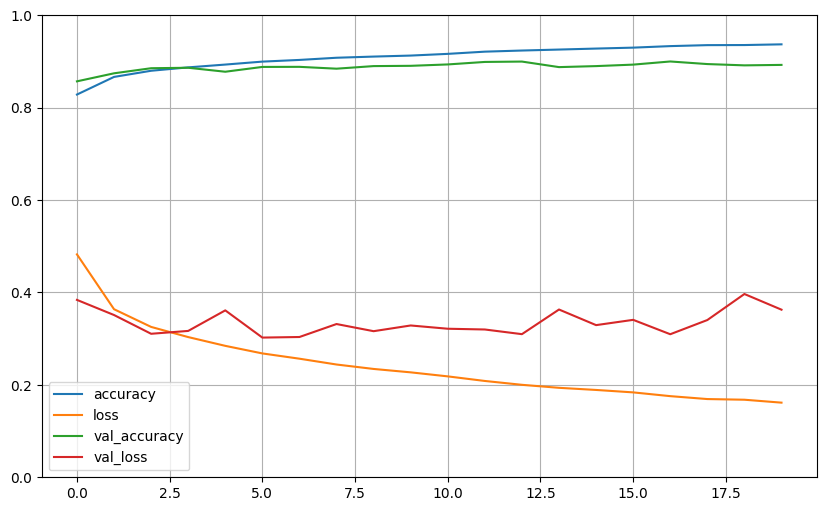

In [213]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(10, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Both the training accuracy and the validation accuracy steadily increase during training, while the training loss and the validation loss decrease. The validation curves are close to the training curves, which means that there is not too much overfitting. Probably the model has not converged yet, as the validation loss is still going down, so we should probably continue training. It’s as simple as calling the fit() method again, since Keras just continues training where it left off. If we are not satisfied with the performance of the model, we can go back and tune the hyperparameters. The first one to check is the **learning rate**. If that doesn’t help, **try another optimizer** (and always retune the learning rate after changing any hyperparameter). If the performance is still not great, then **try tuning model hyperparameters** (number of layers, number of neurons per layer, types of activation functions). We can also try tuning other hyperparameters, such as the **batch size**. Once we are satisfied with the model validation accuracy, we have to evaluate it on the test set to estimate the **generalization error** before we deploy it to production. We can easily do this using the **evaluate()** method:

In [99]:
model.evaluate(X_test, y_test)

196/313 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.8869 - loss: 0.6092

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.8868 - loss: 0.6169


[0.6130345463752747, 0.888700008392334]

Remember to **resist the temptation to tweak the hyperparameters on the test set**, or else your estimate of the generalization error will be too optimistic. Next, we can use the **predict()** method to make predictions on new instances:

In [100]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## Build a Regressor

Let’s switch to the California housing problem and tackle it using a regression neural network. After loading the data, we split it into a training set, a validation set, and a test set:

In [117]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

In [118]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

Using the Sequential API we can to build, train, evaluate, and use a regression MLP to make predictions in a quite similar way to what we did for classification. The main differences are the fact that **the output layer has a single neuron** (since we only want to predict a single value), **it uses no activation function**, and the loss function is the **mean squared error**. Moreover, in this example we don’t need a Flatten layer, and instead we’re using a **Normalization layer** as first layer:

In [142]:
normalization_layer = keras.layers.Normalization(input_shape=X_train.shape[1:])

model = keras.models.Sequential([
    normalization_layer,
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(1)
])

In [144]:
model.compile(loss="mse", optimizer="sgd")

Notice that the normalization layer need to learn the feature means and standard deviations in the
training data and we need to call the adapt() method:

In [145]:
normalization_layer.adapt(X_train)

In [146]:
history = model.fit(X_train, y_train, verbose=0, epochs=20, validation_data=(X_valid, y_valid))

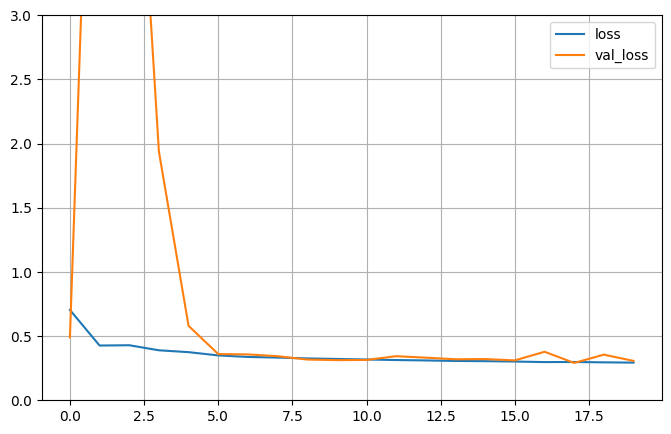

In [147]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

In [148]:
mse_test = model.evaluate(X_test, y_test)

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 0.3099


## Functional API

The Sequential API is quite easy to use. However, although sequential models are extremely common, it is sometimes useful to build neural networks with more **complex topologies**. One example of a non-sequential neural network is a [**Wide & Deep neural network**](https://dl.acm.org/doi/pdf/10.1145/2988450.2988454):

![](images/wide-and-deep.png)

This architecture makes it possible to learn both **deep patterns** (using the deep path) and **simple rules** (through the short path). In contrast, a regular MLP forces all the data to flow through the full stack of layers; thus, simple patterns in the data may end up being distorted by this sequence of transformations. For this purpose, Keras offers the **Functional API**. First, we need to create an Input object. This is a specification of the kind of input the model will get, including its shape and type.  Next, we create a Dense layer using the ReLU activation function. Notice that we call it like a function, passing it the input. This is why this is called the "Functional" API. We are just **telling Keras how it should connect the layers together**. We then create a second hidden layer. Next, we create a **Concatenate layer** to concatenate the input and the output of the second hidden layer.  Then we create the output layer, with a single neuron and no activation function. Finally, we create the model, specifying which inputs an outputs to use:

In [168]:
input_layers = keras.layers.Input(shape=X_train.shape[1:])
normalization_layer = keras.layers.Normalization()
hidden_layer1 = keras.layers.Dense(30, activation="relu")
hidden_layer2 = keras.layers.Dense(30, activation="relu")
concat_layer = keras.layers.Concatenate()
output_layer = keras.layers.Dense(1)

In [169]:
inputs = input_layers
normalized = normalization_layer(inputs)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)
model = keras.Model(inputs=[inputs], outputs=[output])

print(model.summary())

Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_9     │ (None, 8)         │         17 │ input_layer_18[0… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_68 (Dense)    │ (None, 30)        │        270 │ normalization_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, 30)        │        930 │ dense_68[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 38)        │          0 │ normalization_9[… │
│ (Concatenate)       │                   │            │ dense_69[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_70 (Dense)    │ (None, 1)         │         39 │ concatenate_13[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,256 (4.91 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 17 (72.00 B)

None


Once you have built the Keras model, everything is exactly like earlier: we compile the model, train it, evaluate it, and use it to make predictions:

In [170]:
model.compile(loss="mse", optimizer="sgd")

In [171]:
normalization_layer.adapt(X_train)

In [172]:
history = model.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_valid, y_valid))

Epoch 1/20
264/363 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 1.3967

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 1.2249 - val_loss: 3.2115
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 0.5527 - val_loss: 2.7526
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 0.4315 - val_loss: 3.2172
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 0.4138 - val_loss: 15.3235
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 0.6833 - val_loss: 28.9470
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 0.5504 - val_loss: 86.1212
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 1.2497 - val_loss: 34.1522
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 0.7183 - val_loss: 1.0299
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 0.4967 - val_loss: 6.2824
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 0.4116 - val_loss: 37.5429
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 0.5470 - val_loss: 88.3371
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━

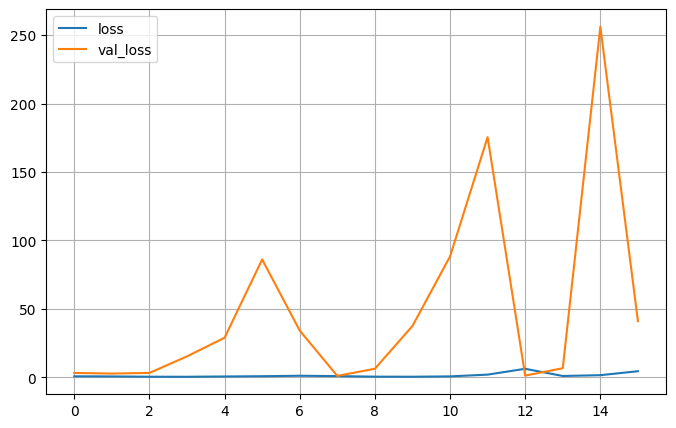

In [173]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 3)
plt.show()

But what if we want to send a subset of the features through the wide path and a different subset (possibly overlapping) through the deep path? One solution is to use **multiple inputs**.  For example, suppose we want to send five features through the wide path (features 0 to 4), and six features through the deep path (features 2 to 7):

![](images/wide-and-deep-multiple-input.png)

In [63]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")

hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

concat = keras.layers.concatenate([input_A, hidden2])

output = keras.layers.Dense(1, name="output")(concat)

model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

print(model.summary())

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ deep_input          │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 30)        │        210 │ deep_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wide_input          │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 30)        │        930 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 35)        │          0 │ wide_input[0][0], │
│ (Concatenate)       │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         36 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,176 (4.59 KB)

 Trainable params: 1,176 (4.59 KB)

 Non-trainable params: 0 (0.00 B)

None


In [65]:
model.compile(loss="mean_squared_error", 
              optimizer="sgd")

In [66]:
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

In [67]:
history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))

Epoch 1/20
  1/363 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - loss: 6.7524

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 1.9297 - val_loss: 0.6534
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 0.4885 - val_loss: 0.4177
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 0.4316 - val_loss: 0.6548
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 0.4233 - val_loss: 0.4780
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 0.4368 - val_loss: 0.3873
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 0.4138 - val_loss: 0.3740
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 0.4169 - val_loss: 0.3701
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - loss: 0.4295 - val_loss: 0.3825
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - loss: 0.3988 - val_loss: 0.3667
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 0.3988 - val_loss: 0.3846
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 0.4033 - val_loss: 0.3976
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 

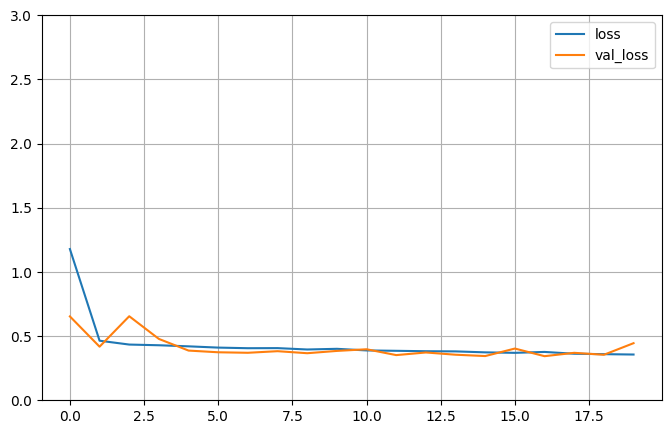

In [68]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

There are many use cases in which we may want to have also **multiple outputs**. For instance, we may want to locate and classify the main object in a picture. This is both a regression task (finding the coordinates of the object’s center, as well as its width and height) and a classification task. Similarly, we may have **multiple independent tasks based on the same data**. we could train one neural network per task, but in many cases we will get better results on all tasks by training a single neural network with one output per task. This is because the neural network can **learn features in the data that are useful across tasks**. For example, we could perform multitask classification on pictures of faces, using one output to classify the person’s facial expression (smiling, surprised, etc.) and another output to identify whether they are wearing glasses or not. Another use case is adding some auxiliary outputs in a neural network architecture to ensure that the underlying part of the network learns something useful on its own, without relying on the rest of the network.

![](images/wide-and-deep-multiple-output.png)

Each output needs its own loss function. Therefore, when we compile the model, we should pass a list of losses. By default, Keras will compute all these losses and simply add them up to get the final loss used for training. We care much more about the main output than about the auxiliary output (as it is just used for regularization), so we want to give the main output’s loss a much greater weight. When we train the model, we need to provide labels for each output. In this example, the main output and the auxiliary output should try to predict the same thing, so they should use the same labels:

Epoch 1/20


363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 1.6085 - val_loss: 1.6217
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 0.5196 - val_loss: 2.1456
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 0.5079 - val_loss: 1.2535
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 0.4782 - val_loss: 0.4252
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 0.4469 - val_loss: 0.4254
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 0.4293 - val_loss: 0.4037
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 0.4150 - val_loss: 0.4079
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 0.4091 - val_loss: 0.5041
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 0.5918 - val_loss: 0.3760
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 0.4015 - val_loss: 0.3975
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 0.4057 - val_loss: 0.3670
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 

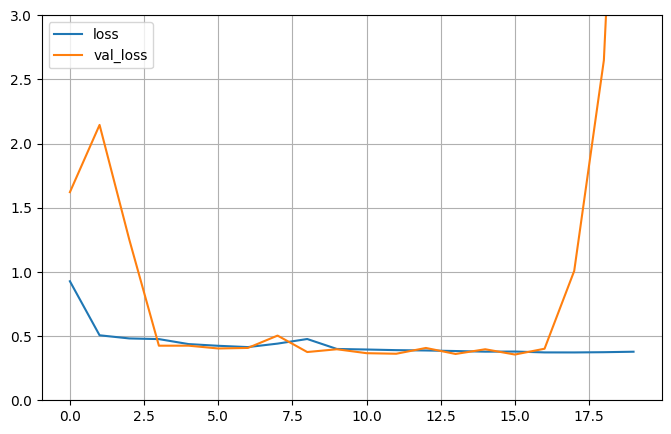

In [70]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)

model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], 
              optimizer="sgd")

history = model.fit([X_train_A, X_train_B], 
                    [y_train, y_train], 
                    epochs=20,
                    validation_data=([X_valid_A, X_valid_B], 
                                     [y_valid, y_valid]))
                
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

When using the Sequential API or the Functional API, saving and loading a trained Keras model is really simple. It will use the **HDF5 format** to save both the model’s architecture (including every layer’s hyperparameters) and the values of all the model parameters for every layer (e.g., connection weights and biases). It also saves the optimizer (including its hyperparameters and any state it may have):

In [72]:
model.save("my_keras_model.keras")
model = keras.models.load_model("my_keras_model.keras")

## Subclassing API

Both the **Sequential API and the Functional API are declarative**: we start by declaring which layers we want to use and how they should be connected, and only then can we start feeding the model some data for training or inference. 

This has many advantages: the model can easily be saved, cloned, and shared, its structure can be displayed and analyzed, the framework can infer shapes and check types, so errors can be caught early.

However, the model is static. Some models involve loops, varying shapes, conditional branching, and other dynamic behaviors. For such cases, or simply if you prefer a more imperative programming style, the **Subclassing API** can be used:

In [74]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

model.compile(loss="mse", loss_weights=[0.9, 0.1], 
              optimizer="sgd")

history = model.fit((X_train_A, X_train_B), 
                    (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), 
                                     (y_valid, y_valid)))

total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), 
                                                 (y_test, y_test))
print('Total loss:', total_loss)
print('Main loss:', main_loss)
print('Aux loss:', aux_loss)

Epoch 1/10


363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 1.4347 - val_loss: 0.5625
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 0.5256 - val_loss: 1.8769
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 0.5097 - val_loss: 15.9975
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 0.6097 - val_loss: 9.9907
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 0.5595 - val_loss: 0.4414
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 0.4464 - val_loss: 0.4260
Epoch 7/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 0.4277 - val_loss: 0.4098
Epoch 8/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 0.4243 - val_loss: 0.4017
Epoch 9/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 0.4062 - val_loss: 0.4044
Epoch 10/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 0.4237 - val_loss: 0.3854
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 0.3856


TypeError: cannot unpack non-iterable float object

The big difference is that we can do pretty much anything we want in the call() method: for loops, if statements, low-level TensorFlow operations, etc... This makes it a great API for researchers experimenting with new ideas.

However, the model’s architecture is hidden within the call() method, so Keras cannot easily inspect it, it cannot save or clone it and the summary() method can provide jusrt a list of layers, without any information on how they are connected to each other. Moreover, Keras cannot check types and shapes ahead of time, and it is easier to make mistakes. 

So unless we really need extra flexibility, we should probably stick to the Sequential API or the Functional API.

The saving an loafing feature will work when using the Sequential API or the Functional API, but unfortunately not when using model subclassing. In that case, we can use **save_weights()** and **load_weights()** to at least save and restore the model parameters, but we will need to save and restore everything else ourself:

In [ ]:
model.save_weights("my_keras_weights.ckpt")
model.load_weights("my_keras_weights.ckpt")

## Callbacks

What if training lasts several hours? This is quite common, especially when training on large datasets. In this case, we should not only save our model at the end of training, but also save **checkpoints** at regular intervals during training, to avoid losing everything in case of crashes. For this we can use the possibility to pass **callbacks functions** to the fit() method that Keras will call at the start and end of training, at the start
and end of each epoch, and even before and after processing each batch:

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
]) 

model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", 
                                                save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

model = keras.models.load_model("my_keras_model.h5")

mse_test = model.evaluate(X_test, y_test)

In the example, the **ModelCheckpoint callback** saves checkpoints of our model at regular intervals during training, by default at the end of each epoch. Moreover, if we use a validation set during training, by setting
**save_best_only=True**  it will only save the model when its performance on the validation set is the best so far. This is a simple way to implement the **early stopping** concept. We can use also the **EarlyStopping callback**, that interrupt training when it measures no progress on the validation set for a number of epochs (defined by the **patience argument**). We can combine both callbacks to save checkpoints of your model (in case your computer crashes) and interrupt training early when there is no more progress (to avoid wasting time and resources). 

There are many other callbacks available in the keras.callbacks package and it is possible to write also custom callbacks, by implementing **on_train_begin()**, **on_train_end()**, **on_epoch_begin()**, **on_epoch_end()**, **on_batch_begin()**, and **on_batch_end()**. 

Callbacks can also be used during evaluation and predictions, should we ever need them (e.g., for debugging). For evaluation, we should implement **on_test_begin()**, **on_test_end()**, **on_test_batch_begin()**, or **on_test_batch_end()** during the evaluation; and **on_predict_begin()**, **on_predict_end()**, **on_predict_batch_begin()** and **on_predict_batch_end()** during prediction.

In [ ]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))
        
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

## TensorBoard

TensorBoard is an interactive visualization tool of TensorFlow that ywe can use to view the learning curves during training, compare learning curves between multiple runs, visualize the computation graph, analyze training statistics, view images generated by our models, visualize complex multidimensional data projected down to 3D and automatically clustered, etc...

To use it, we need to modify the program so that it outputs the data to special binary log files called **event files**. Each binary data record is called a **summary**. 

The TensorBoard server will monitor the log directory, and it will automatically pick up the changes and update the visualizations: this allows the visualization of live data such as the learning curves during training. 

In [ ]:
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

#%load_ext tensorboard
#%tensorboard --logdir=./my_logs --port=6006

In the example, we define the root log directory and we use a small function that will generate a subdirectory path based on the current date and time so that it’s different at every run. We can also to include extra information in the log directory name, such as hyperparameter values that you are testing, to make it easier to know what you are looking at in TensorBoard.  Then we make use of the Keras callback for Tensor Board.

We can use TensorBoard directly within Jupyter or we can start it from the command line running the following command at the root of the project (or from anywhere else, as long as you point to the appropriate log directory).

$ tensorboard --logdir=./my_logs --port=6006

Once the server is up, you can open a web browser and go to http://localhost:6006.